# Spotify Playlist Comparator

**Playlist Analysis with Object-Oriented Approach**: Instead of having to work with much of the irrelevant information that is carried for each object, I used an object-oriented approach in order to structure Users, Playlists, and Tracks in a way that would be more accessible for me.

## Dependencies

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
import spotipy

from sklearn import preprocessing
from spotipy.oauth2 import SpotifyOAuth
from credentials import SPOTIPY_CLIENT_ID, SPOTIPY_CLIENT_SECRET, SPOTIPY_REDIRECT_URI

scope = "user-library-read"

## User-Playlist-Track Structure

In [2]:
class CurrentUser:
    """Represents a unique Spotify user using Spotipy OAuth2."""
    sp = spotipy.Spotify(
            auth_manager=SpotifyOAuth(scope=scope, 
            client_id=SPOTIPY_CLIENT_ID, 
            client_secret=SPOTIPY_CLIENT_SECRET,
            redirect_uri=SPOTIPY_REDIRECT_URI)
    )
    
    def __init__(self):
        self.display_name = self.sp.current_user()['display_name']
        self.id = self.sp.current_user()['id']
        self.playlists = []
        
        self.write_playlists_to_user()
        
    def write_playlists_to_user(self):
        playlists = self.sp.current_user_playlists()['items']
        for playlist in playlists:
            playlist_id = playlist['id']
            new_playlist = Playlist(playlist_id)
            self.playlists.append(new_playlist)
    
    def __repr__(self):
        """Returns a representation of the CurrentUser object"""
        return f"Current User: {self.display_name}"

In [3]:
class Playlist:
    """Represents a unique spotify Playlist for a given user."""
    user = CurrentUser.sp.current_user()['id']
    
    def __init__(self, playlist_id):
        """Creates an instance of the Playlist object"""
        self.name = CurrentUser.sp.playlist(playlist_id)['name']
        self.id = playlist_id
        self.items = []
        
        self.write_tracks_to_items()
        
    def write_tracks_to_items(self):
        """Creates a list of Track objects within the playlist"""
        tracks_raw = CurrentUser.sp.playlist(self.id)['tracks']['items']
        for track in tracks_raw:
            new_track_id = track['track']['id']
            new_track = Track(new_track_id)
            self.items.append(new_track)
            
    def __repr__(self):
        """Returns a representation of the Playlist object."""
        return f"{self.name}, {self.user}'s playlist"
    
    def to_df(self):
        """Converts the given playlist into a Pandas DataFrame."""
        column_labels = ['danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 
                         'instrumentalness', 'liveness', 'valence', 'tempo', 'type', 'id', 'uri', 'track_href', 
                         'analysis_url', 'duration_ms', 'time_signature']

        features_df = pd.DataFrame(columns=column_labels)
        
        for track in self.items:
            features = CurrentUser.sp.audio_features(track.id)[0]
            dataframe = pd.DataFrame(data=features, index=[track.name])
            features_df = features_df.append(dataframe, sort=False)
        features_df.name = self.name
            
        return features_df

In [4]:
class Track:
    """Represents a given Track on a user's playlist."""
    user = CurrentUser.sp.current_user()['id']
    
    def __init__(self, track_id):
        "Creates an instance of the Track class object."
        self.name = CurrentUser.sp.track(track_id)['name']
        self.id = track_id
        self.artist = CurrentUser.sp.track(track_id)['artists'][0]['name']
    
    def __repr__(self):
        """Returns a representation of the Track object."""
        return f"{self.name} by {self.artist}"

## Plotting Tools for Visualization

In [5]:
def plot_feature(df, feature):
    """Plots the distribution of a given audio feature across a group of tracks"""
    sns.distplot(df[feature], label=df.name)
    plt.xlabel(f'{feature}', fontsize=18)
    plt.grid(True)

In [6]:
def plot_analysis(df):
    """Creates a 12 element plot that visualizes all audio features for a group of tracks"""
    features = list(df.columns[0:11]) + list(df.columns[-1:])
    plt.figure(figsize=(20,20))
    for (i, feature) in zip(range(1,13), features):
        plt.subplot(4,3,i)
        plot_feature(df, feature) 
    plt.suptitle('Visual Analysis of Spotify Playlist')
    plt.tight_layout()

In [7]:
def compare(*args):
    """Overlays the audio analysis of two or more groups of tracks to easily compare differences"""
    features = list(args[0].columns[0:11]) + ['duration_ms']
    plt.figure(figsize=(20,20))
    for (i,feature) in zip(range(1,13), features):
        plt.subplot(4,3,i)
        for df in args:
            plot_feature(df, feature)
            plt.legend()
    plt.suptitle('Comparison of User Playlists', y=1.03, fontsize=25)
    plt.tight_layout()

## Tools for Matching Score

In [8]:
def standardize_df(df):
    """Returns a standardized version of the features DataFrame using sci-kit learn"""
    features = list(df.columns[0:11]) + ['duration_ms']
    new_df = df.iloc[:,list(range(11)) + [16]]
    x = new_df.values
    min_max_scaler = preprocessing.MinMaxScaler()
    x_scaled = min_max_scaler.fit_transform(x)
    return pd.DataFrame(data=x_scaled, columns=features)

In [9]:
def diagonalize(df):
    """ Returns a matrix multiplicationf of A-tranpose multiplied by A to get q square matrix."""
    standard = standardize_df(df).to_numpy()
    return np.matmul(np.transpose(standard), standard)

In [10]:
def rmse(df1, df2):
    """Computes the Root Mean Squared Error between two standardized DataFrames"""
    return np.mean((df1.mean() - df2.mean())**2)**(0.5)

In [11]:
def matching_score(df1, df2):
    """Computes a theoretical matching score between two playlists in terms of their audio features."""
    df1_standard = standardize_df(df1)
    df2_standard = standardize_df(df2)
    theoretical_score = rmse(df1_standard, df2_standard)
    if not theoretical_score:
        print("Playlists are identical.")
        return
    return 1 / theoretical_score

In [12]:
def alternative_matching_score(df1, df2):
    """Uses techniques from linear algebra to compute an alternative matching score. """
    diagonal1, diagonal2 = diagonalize(df1), diagonalize(df2)
    score = 0
    diff = diagonal1 - diagonal2
    for feature in diff:
        score += np.mean(feature)
        
    return abs(score)

## Loading Current User's Library

The following cell will load all of the Current User's relevant information into the hierarchy that is established above. It will iterate through all of the user's playlists and create instances of each. Then, it will populate itself with Track objects -- consisting of a name, artist and Spotify ID.

In [ ]:
user = CurrentUser()

In [ ]:
user.playlists

In [ ]:
quantum = user.playlists[0]
quantum_df = quantum.to_df()

nonlinear = user.playlists[2]
nonlinear_df = nonlinear.to_df()

homeostasis = user.playlists[8]
homeostasis_df = homeostasis.to_df()

workout = user.playlists[13]
workout_df = workout.to_df()

supa = user.playlists[15]
supa_df = supa.to_df()

## Visualizing Playlist Differences

The below cell utilizes special plotting functions defined above to compare the distribution of each audio feature for all the playlists. This function can compare two or more DataFrames. Theses DataFrames can be obtained from the Playlist object by calling the `.to_df()` method on each instance of a User's playlists.

In [ ]:
compare(supa_df, homeostasis_df, nonlinear_df)

## How Similar are My Playlists?

By taking the RMSE values between two arrays representative of two Playlists, I am able to compute a theoretical matching score between two Playlists. These, of course, are normalized to avoid any biases.

In [ ]:
matching_score(workout_df, supa_df)

In [ ]:
matching_score(quantum_df, supa_df)

In [ ]:
matching_score(quantum_df, nonlinear_df)

In [ ]:
matching_score(quantum_df, homeostasis_df)

In [ ]:
matching_score(workout_df, homeostasis_df)

In [ ]:
matching_score(supa_df, homeostasis_df)

In [ ]:
matching_score(quantum_df, quantum_df)

## Comparing Different User's Playlists

In [13]:
quantum = Playlist("spotify:playlist:5RMXhT59sies1LaExYEPKY")
bkgnd = Playlist("spotify:playlist:3kMZM5jiZ6ClsObXQ7mA4i")
seaweed = Playlist("spotify:playlist:1uZJKvJr7wJITkwYQ9cNNM")

In [14]:
quantum_df = quantum.to_df()
bkgnd_df = bkgnd.to_df()
seaweed_df = seaweed.to_df()

In [ ]:
matching_score(quantum_df, bkgnd_df)

In [ ]:
matching_score(quantum_df, seaweed_df)

In [ ]:
alternative_matching_score(quantum_df, seaweed_df)

/Users/willfurtado/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/willfurtado/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/willfurtado/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level functio

/Users/willfurtado/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/Users/willfurtado/opt/anaconda3/lib/python3.7/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


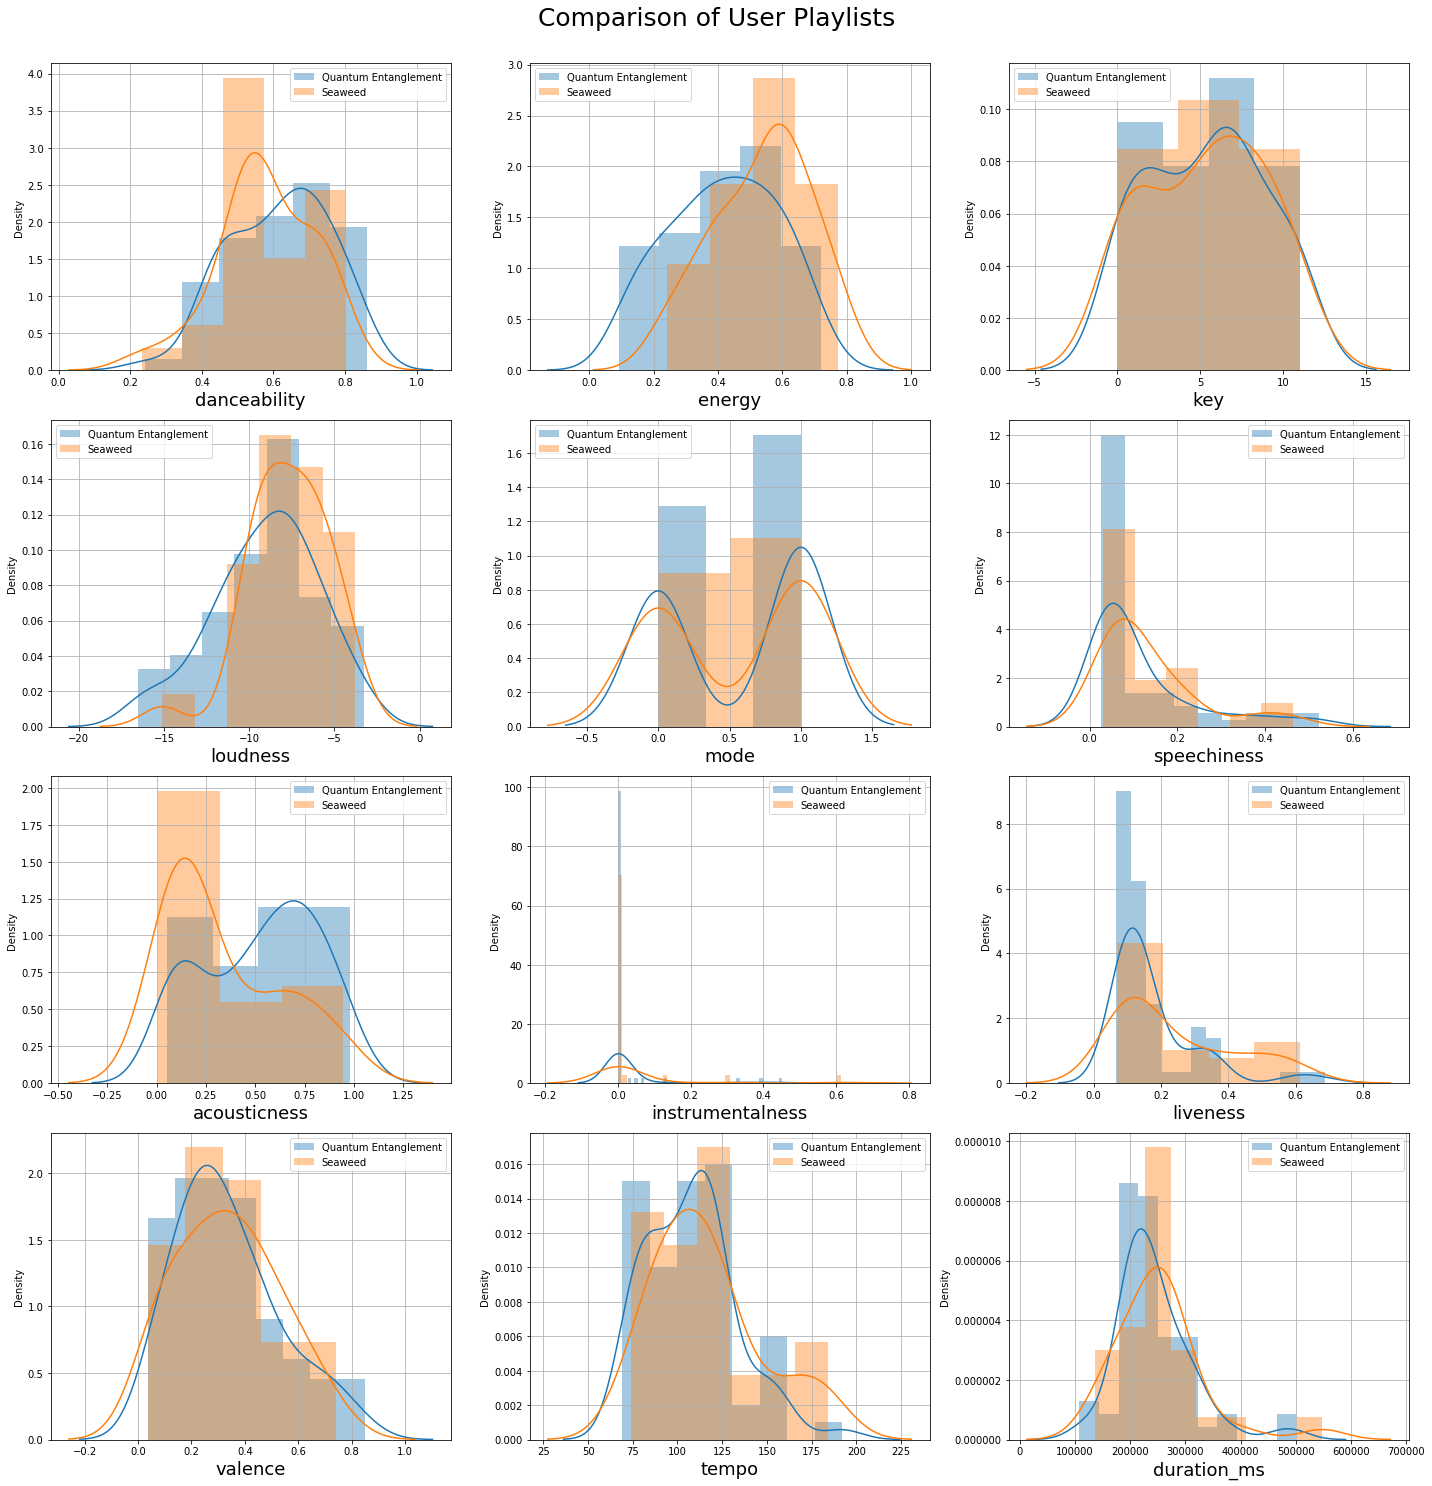

In [17]:
compare(quantum_df, seaweed_df)

In [16]:
compare(nonlinear_df, bkgnd_df)

NameError: name 'nonlinear_df' is not defined